In [127]:
import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import sympy as sym
from scipy.optimize import curve_fit

matplotlib.rcParams.update({
    'font.family': 'serif',
    'text.usetex': True,
    'axes.labelsize': 'large',
    'figure.dpi': 100,
})

In [14]:
# Import all measurements from the `./measurements` directory. Each measurement file
# is read into a numpy array (column-first) and added to the `meas_dict` (keys are
# filenames with extentions removed).
meas_dir = os.fsencode('./measurements')
meas_dict = {}
for fname in os.listdir(meas_dir):
    with open(os.path.join(meas_dir, fname)) as file:
        meas = [[float(el) for el in row.split(',')]
                for row in file.readlines()]
        meas_name = os.fsdecode(fname).removesuffix('.csv')
        meas_dict[meas_name] = np.array(meas).T

In [44]:
print(str.join('',
    [f'{t_p:.3f} & {t_v:.3f} & {t_k:.3f} & {t_z:.3f} \\\\\n'
     for t_p, t_v, t_k, t_z in sorted(zip(t_p, t_v, t_k, t_z))]
))

NameError: name 't_p' is not defined

(48.849335317274736, 5.755898998454651)

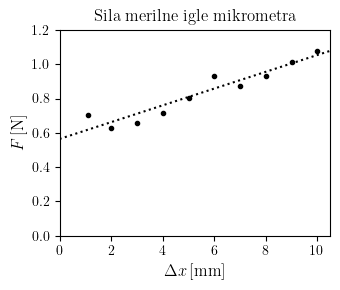

In [27]:
Δx, m = meas_dict['needle-force']
Δx, F_needle = 1e-3 * Δx, 9.81 * 1e-3 * m

# Calculate micrometer needle string coefficient.
def linear(x, k, c):
    return k*x + c

par, cov = curve_fit(linear, Δx, F_needle)
k_needle, F_g_needle = par
σ_k_needle, σF_g_needle = np.sqrt(np.diag(cov))

# Plot
fig, ax = plt.subplots(1, 1, figsize=[3.5, 3])

ax.scatter(1e3 * Δx, F_needle, marker='.', color='black')
Δx_lin = np.linspace(0, 10.5)
ax.plot(1e3 * Δx_lin, k_needle*Δx_lin + F_g_needle, color='black', linestyle=':',)

# Labels and style.
ax.set_title('Sila merilne igle mikrometra')
ax.set_xlabel(r'$\Delta x\,[\mathrm{mm}]$')
ax.set_ylabel(r"$F\,[\mathrm{N}]$")
ax.set_xlim(0, 10.5)
ax.set_ylim(0, 1.2)
fig.tight_layout()
fig.savefig('needle.pdf')
k_needle, σ_k_needle

(2.0008333333333337e-10,
 2.286666666666667e-12,
 107.44474422170005,
 1.2976467416357198,
 43.87327055719418,
 0.732233053918005,
 0.4457660838050534,
 0.008143403270498093,
 9730.320699708454,
 91.73904594744717)

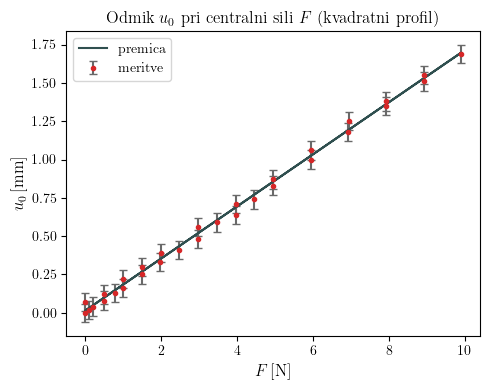

In [124]:
# Square rod.
u_0, m = meas_dict['bend-u-square']
u_0, m = 1e-3 * u_0, 1e-3 * m
F = (9.81 * m) + k_needle*u_0

a, Δa = 7e-3, 0.02e-3
ℓ, Δℓ = 56e-2, 0.02e-2
m, Δm = 267e-3, 2e-3

# Moment and density.
J = a**4 / 12
ΔJ = 4*a**3 / 12 * Δa
ρ = m / (a**2 * ℓ)
Δρ = np.sqrt(
    (1 / (a**2 * ℓ) * Δm)**2 +
    (-2*m / (a**3 * ℓ) * Δa)**2 +
    (-m / (a**2 * ℓ**2) * Δℓ)**2
)

# Calculate Young modulus.
par, cov = curve_fit(
    linear, F, u_0, sigma=[0.06e-3]*len(F), absolute_sigma=True)
k, c = par
σ_k, σ_c = np.sqrt(np.diag(cov))
E = ℓ**3 / (48 * J * k)
ΔE = np.sqrt(
    (3*ℓ_k**2 / (48 * J * k) * Δℓ)**2 +
    (-ℓ**3 / (2 * 48 * J**2 * k) * ΔJ)**2 +
    (-ℓ**3 / (2 * 48 * J * k**2) * σ_k)**2
)

# Max force for 0.1% deformation.
F_max = 8*E*J*0.1e-2 / (a*ℓ)
ΔF_max = np.sqrt(
    (8*1*J*0.1e-2 / (a*ℓ) * ΔE)**2 +
    (8*E*1*0.1e-2 / (a*ℓ) * ΔJ)**2 +
    (-4*E*J*0.1e-2 / (a**2 * ℓ) * Δa)**2 +
    (-4*E*J*0.1e-2 / (a * ℓ**2) * Δℓ)**2
)

# Deformation because of its own weight.
u_g = (9.81*m) * ℓ**3 / (48 * E*J)
Δu_g = np.sqrt(
    ((9.81*1) * ℓ**3 / (48 * E*J) * Δm)**2 +
    ((9.81*m) * 3*ℓ**2 / (48 * E*J) * Δℓ)**2 +
    (-(9.81*m) * ℓ**3 / (48 * E**2 * J) * ΔE)**2 +
    (-(9.81*m) * ℓ**3 / (48 * E * J**2) * ΔJ)**2
)

# Plot.
fig, ax = plt.subplots(1, 1, figsize=[5, 4])

# Plot u_0(F) and model line.
ax.errorbar(F, 1e3 * u_0, yerr=0.06,
            fmt='.', color='tab:red', ecolor='dimgray', capsize=3, label='meritve')
ax.plot(F, 1e3 * (k*F + c), color='darkslategray', label='premica')

# Labels and style.
ax.set_title('Odmik $u_0$ pri centralni sili $F$ (kvadratni profil)')
ax.set_xlabel(r'$F\,[\mathrm{N}]$')
ax.set_ylabel(r"$u_0\,[\mathrm{mm}]$")
ax.legend()
fig.tight_layout()
fig.savefig('square.pdf')

J, ΔJ, 1e-9 * E, 1e-9 * ΔE, F_max, ΔF_max, 1e3 * u_g, 1e3 * Δu_g, ρ, Δρ

43.87327055719418

(1.178588118948296e-10,
 1.346957850226624e-12,
 110.93214903824706,
 1.9506105954017472,
 26.68230874813869,
 0.5608657967788462,
 0.5874706026364179,
 0.008275677075339953,
 9929.78362147685,
 108.83173542436315)

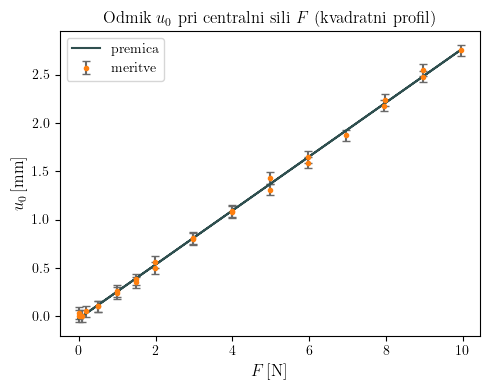

In [128]:
# Square rod.
u_0, m = meas_dict['bend-u-round']
u_0, m = 1e-3 * u_0, 1e-3 * m
F = (9.81 * m) + k_needle*u_0

d, Δd = 7e-3, 0.02e-3
ℓ, Δℓ = 56e-2, 0.02e-2
m, Δm = 214e-3, 2e-3

# Moment and density.
J = np.pi * (d/2)**4 / 4
ΔJ = np.pi * (d/2)**3 / 2 * Δd
ρ = m / (np.pi * (d/2)**2 * ℓ)
Δρ = np.sqrt(
    (1 / (np.pi * (d/2)**2 * ℓ) * Δm)**2 +
    (-m / (np.pi * (d/2)**3 * ℓ) * Δd)**2 +
    (-m / (np.pi * (d/2)**2 * ℓ**2) * Δℓ)**2
)

# Calculate Young modulus.
par, cov = curve_fit(
    linear, F, u_0, sigma=[0.06e-3]*len(F), absolute_sigma=True)
k, c = par
σ_k, σ_c = np.sqrt(np.diag(cov))
E = ℓ**3 / (48 * J * k)
ΔE = np.sqrt(
    (3*ℓ_k**2 / (48 * J * k) * Δℓ)**2 +
    (-ℓ**3 / (48 * J**2 * k) * ΔJ)**2 +
    (-ℓ**3 / (48 * J * k**2) * σ_k)**2
)

# Max force for 0.1% deformation.
F_max = 8*E*J*0.1e-2 / (d*ℓ)
ΔF_max = np.sqrt(
    (8*1*J*0.1e-2 / (d*ℓ) * ΔE)**2 +
    (8*E*1*0.1e-2 / (d*ℓ) * ΔJ)**2 +
    (-4*E*J*0.1e-2 / (d**2 * ℓ) * Δd)**2 +
    (-4*E*J*0.1e-2 / (d * ℓ*2) * Δℓ)**2
)

# Deformation because of its own weight.
u_g = (9.81*m) * ℓ**3 / (48 * E*J)
Δu_g = np.sqrt(
    ((9.81*1) * ℓ**3 / (48 * E*J) * Δm)**2 +
    ((9.81*m) * 3*ℓ**2 / (48 * E*J) * Δℓ)**2 +
    (-(9.81*m) * ℓ**3 / (2 * 48 * E**2 * J) * ΔE)**2 +
    (-(9.81*m) * ℓ**3 / (2 * 48 * E * J**2) * ΔJ)**2
)

# Plot.
fig, ax = plt.subplots(1, 1, figsize=[5, 4])

# Plot u_0(F) and model line.
ax.errorbar(F, 1e3 * u_0, yerr=0.06,
            fmt='.', color='tab:orange', ecolor='dimgray', capsize=3, label='meritve')
ax.plot(F, 1e3 * (k*F + c), color='darkslategray', linestyle='-', label='premica')

# Labels and style.
ax.set_title('Odmik $u_0$ pri centralni sili $F$ (kvadratni profil)')
ax.set_xlabel(r'$F\,[\mathrm{N}]$')
ax.set_ylabel(r"$u_0\,[\mathrm{mm}]$")
ax.legend()
fig.tight_layout()
fig.savefig('round.pdf')

J, ΔJ, 1e-9 * E, 1e-9 * ΔE, F_max, ΔF_max, 1e3 * u_g, 1e3 * Δu_g, ρ, Δρ